In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits

In [121]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image

torch.manual_seed(101)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [122]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the main folder path
main_folder = '/kaggle/input/astronomy-fits-dataset/Astro/'

filepaths = []
labels = []
dataset_types = []
class_ids = []

class_id_counter = 0
x,y=0,0
for class_folder in os.listdir(main_folder):
    class_path = os.path.join(main_folder, class_folder)
    
    if os.path.isdir(class_path):
        current_class_id = class_id_counter
        class_id_counter += 1
        
        inner_class_folder_path = os.path.join(class_path, class_folder)
        
        if os.path.isdir(inner_class_folder_path):
            for filename in os.listdir(inner_class_folder_path):
                if filename.endswith(('fits')):  # Check for valid image files
                    
                    file_path = os.path.join(inner_class_folder_path, filename)
                    relative_path = os.path.relpath(file_path, main_folder)
                    
                    filepaths.append(relative_path)
                    labels.append(class_folder)
                    class_ids.append(current_class_id)

            train_paths, test_paths = train_test_split(filepaths[-len(filepaths):], test_size=0.3, random_state=42)
            
            dataset_types.extend(['train'] * (len(train_paths)-x))
            dataset_types.extend(['test'] * (len(test_paths)-y))
            x= len(train_paths)
            y = len(test_paths)

df = pd.DataFrame({
    'class_id': class_ids,
    'filepaths': filepaths,
    'labels': labels,
    'data-set': dataset_types
})

In [123]:
PATH = "/kaggle/input/astronomy-fits-dataset/Astro"
class AstroDataset(Dataset):
    def __init__(self, data, transform=None, data_augmentation=False):
        self.data = data.reset_index(drop=True)
        self.transform = transform
        self.initial_transform = transforms.Compose([
            transforms.PILToTensor(),
        ])
        # Add data augmentation if True
        # This will add a random flip of the image 50% of the time when batching
        input_transforms = [
            transforms.Normalize(
                mean=(448),
                std=(225)
            ),
        ] + ([transforms.RandomHorizontalFlip()] if data_augmentation else [])
        #input_transforms =  ([transforms.RandomHorizontalFlip()] if data_augmentation else [])
        self.input_transform = transforms.Compose(input_transforms)
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        class_id = self.data.loc[idx, 'class_id']
        file_path = self.data.loc[idx, 'filepaths']
        name = self.data.loc[idx, 'labels']
        
        try:
            fits_to_array = fits.open(f"{PATH}/{file_path}")[0].data
        except:
            print(file_path)
            fits_to_array = fits.open(f"{PATH}/nebulae/nebulae/Barnard 33.fits")[0].data
            class_id = 2
            
        normalized_array = (fits_to_array - np.min(fits_to_array)) / (np.max(fits_to_array) - np.min(fits_to_array)) * 255
        arr = normalized_array.astype(np.uint8)

        img = Image.fromarray(arr, mode='L')
        img_resized = img.resize((892, 892))
        image = transforms.functional.rotate(self.initial_transform(img_resized), 90)
        if self.transform:
            image = self.transform(image)
        img_input = self.input_transform(image.float())
        image = image.transpose(2,0).detach().numpy()
        
        sample = {'targets': class_id, 'inputs': img_input, 'images': image, 'names': name}
        return sample

In [124]:
train_data = df[df['data-set'] == 'train']
test_data = df[df['data-set'] == 'test']
len(train_data), len(test_data)

(844, 363)

In [125]:
df.head()

,class_id,filepaths,labels,data-set
0,0,stars/stars/HD 93083.fits,stars,train
1,0,stars/stars/HD 49674.fits,stars,train
2,0,stars/stars/HR 2282.fits,stars,train
3,0,stars/stars/HR 5107.fits,stars,train
4,0,stars/stars/HD 8574.fits,stars,train


In [126]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(AstroDataset(train_data, data_augmentation=True), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(AstroDataset(test_data), batch_size=batch_size, shuffle=False)

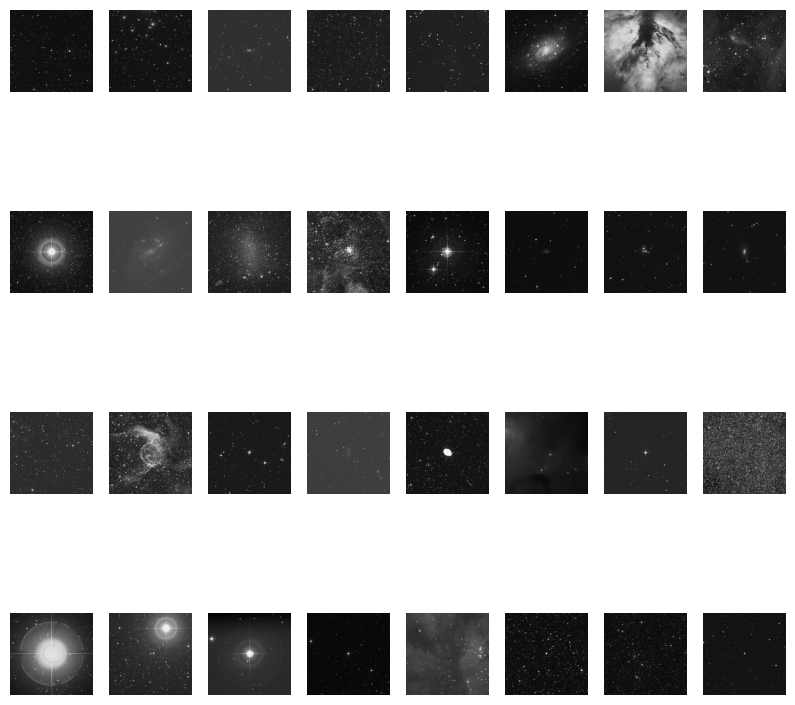

In [127]:
single_batch = next(iter(train_loader))

fig, axes = plt.subplots(batch_size // 8, 8, figsize=(10,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(single_batch['images'][i], cmap='gray')
    ax.set_axis_off()

In [128]:
import torch
import torchvision.models as models

# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)
model.conv1 = torch.nn.Conv2d(1, model.conv1.out_channels, 
                                 kernel_size=model.conv1.kernel_size, 
                                 stride=model.conv1.stride, 
                                 padding=model.conv1.padding, 
                                 bias=model.conv1.bias)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [129]:
# Freeze all the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

In [130]:
# Modify the last layer of the model
num_classes = 4 # replace with the number of classes in your dataset
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)


In [131]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)


In [147]:
def train(model, train_loader,val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        # Set the model to train mode
        model.train()

        running_loss = 0.0
        running_corrects = 0

        for  i in train_loader:
            inputs = i['inputs'].to(device)
            labels = i['targets'].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / len(train_data)
        train_acc = running_corrects.double() / len(train_data)

        model.eval()

        running_loss = 0.0
        running_corrects = 0
        
        with torch.no_grad():
            for i in val_loader:
                inputs = i['inputs'].to(device)
                labels = i['targets'].to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Update the running loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        val_loss = running_loss / len(test_data)
        val_acc = running_corrects.double() / len(test_data)

        print('Epoch [{}/{}], train loss: {:.4f}, train acc: {:.4f}, val loss: {:.4f}, val acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))
        


In [148]:
model = model.to(device)


In [149]:
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)
train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)

# Unfreeze all the layers and fine-tune the entire network for a few more epochs
for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train(model, train_loader, test_loader, criterion, optimizer, num_epochs=50)

/tmp/ipykernel_36/1716558618.py:37: RuntimeWarning: overflow encountered in scalar subtract
  normalized_array = (fits_to_array - np.min(fits_to_array)) / (np.max(fits_to_array) - np.min(fits_to_array)) * 255


nebulae/nebulae/NGC 1554.fits
stars/stars/HAT-P-15.fits
stars/stars/WASP-50.fits
Epoch [1/10], train loss: 0.2322, train acc: 0.9230, val loss: 0.6901, val acc: 0.7741
nebulae/nebulae/NGC 1554.fits
stars/stars/HAT-P-15.fits
stars/stars/WASP-50.fits
Epoch [2/10], train loss: 0.2108, train acc: 0.9265, val loss: 0.6659, val acc: 0.7796
stars/stars/HAT-P-15.fits
nebulae/nebulae/NGC 1554.fits
stars/stars/WASP-50.fits
Epoch [3/10], train loss: 0.2124, train acc: 0.9242, val loss: 0.6873, val acc: 0.7961
stars/stars/WASP-50.fits
stars/stars/HAT-P-15.fits
nebulae/nebulae/NGC 1554.fits
Epoch [4/10], train loss: 0.2192, train acc: 0.9218, val loss: 0.7909, val acc: 0.7686
nebulae/nebulae/NGC 1554.fits
stars/stars/WASP-50.fits
stars/stars/HAT-P-15.fits
Epoch [5/10], train loss: 0.1375, train acc: 0.9597, val loss: 0.6661, val acc: 0.7961
stars/stars/WASP-50.fits
stars/stars/HAT-P-15.fits
nebulae/nebulae/NGC 1554.fits
Epoch [6/10], train loss: 0.1558, train acc: 0.9526, val loss: 0.7057, val acc:

KeyboardInterrupt: 

In [150]:
correct = 0
total = 0

with torch.no_grad():
    for i in test_loader:
        images, labels = i['inputs'].to('cuda'), i['targets'].to('cuda')  # Move to GPU if available
        outputs = model(images)
        #print(images.shape)
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted.shape)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test dataset: {accuracy:.2f}%')


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Collect the true and predicted labels
all_labels = []
all_preds = []

with torch.no_grad():
    for i in test_loader:
        images, labels = i['inputs'].to('cuda'), i['targets'].to('cuda')
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
